BUILDING A SIMPLE VECTOR EMBEDDING

In [ ]:
# VECTOR STORE! (it is an ordered list/ scalars, every element is called as an component)

'''
these are the features or the embeddings of the objects
IT IS SAME AS THE ORCHESTRATION TOOL LIKE FIAS, CHROMA USING ORCHESTRATING TOOLS LIKE LANGCHAIN, LLAMA INDEX
'''

# v =[2,-1,3] a vector with three dimension OR components

# types :
# SPARSE(zero components(when the data has lot of dimensions) eg: one hot encoding) eg:[0,1,0,0,0,0]
#  and
# DENSE(non-zero values, hold some information) eg: [1,-2,3,9]

'''
VECTOR STORE IMPLEMENTATION:
'''
# data structure
# storage format
# loading the vector
# indexing : hash map  ,(k-d trees, ball trees)
# querying
# update
# memory management


In [15]:
import numpy as np

class VectorStore:
    def __init__(self):
      # STORAGE FORMAT
        self.vector_data = {}  # A dictionary to store vectors
        self.vector_index = {}  # An indexing structure for retrieval

    def add_vector(self, vector_id, vector):
        """
        Add a vector to the store.

        Args:
            vector_id (str or int): A unique identifier for the vector.
            vector (numpy.ndarray): The vector data to be stored.
        """
        self.vector_data[vector_id] = vector
        self._update_index(vector_id, vector)

    def get_vector(self, vector_id):
        """
        Retrieve a vector from the store.

        Args:
            vector_id (str or int): The identifier of the vector to retrieve.

        Returns:
            numpy.ndarray: The vector data if found, or None if not found.
        """
        return self.vector_data.get(vector_id)

    def _update_index(self, vector_id, vector):

      norm = np.linalg.norm(vector)
      for existing_id, existing_vector in self.vector_index.items():
          if existing_id == vector_id:
              continue
          distance = np.linalg.norm(vector - existing_vector)
          self.index.setdefault(vector_id, {})[existing_id] = distance
          self.index[existing_id].setdefault(vector_id, distance)
          # Calculate and store weight for edge (smaller distance implies higher weight)
          self.index[existing_id][vector_id] = 1 / distance  # Invert distance for higher weight for closer vectors


    # def _update_index(self, vector_id, vector):
        # """
        # Update the index with the new vector.

        # Args:
        #     vector_id (str or int): The identifier of the vector.
        #     vector (numpy.ndarray): The vector data.
        # """
        # In this simple example, we use brute-force cosine similarity for indexing
    #     for existing_id, existing_vector in self.vector_data.items():
    #         similarity = np.dot(vector, existing_vector) / (np.linalg.norm(vector) * np.linalg.norm(existing_vector))
    #         if existing_id not in self.vector_index:
    #             self.vector_index[existing_id] = {}
    #         self.vector_index[existing_id][vector_id] = similarity

    def find_similar_vectors(self, query_vector, num_results=5):
        """
        Find similar vectors to the query vector using brute-force search.

        Args:
            query_vector (numpy.ndarray): The query vector for similarity search.
            num_results (int): The number of similar vectors to return.

        Returns:
            list: A list of (vector_id, similarity_score) tuples for the most similar vectors.
        """
        results = []
        for vector_id, vector in self.vector_data.items():
            similarity = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector))
            results.append((vector_id, similarity))

        # Sort by similarity in descending order
        results.sort(key=lambda x: x[1], reverse=True)

        # Return the top N results
        return results[:num_results]


In [17]:

import numpy as np

# Create a VectorStore instance
vector_store = VectorStore()

# Define your sentences
sentences = [
"I am vegetarian",
"I eat chicken",
              "I love fried chips",
              "I love to pet cows and goats",
              "I like biriyani"
]

# Tokenization and Vocabulary Creation
vocabulary = set()
for sentence in sentences:
    tokens = sentence.lower().split()
    vocabulary.update(tokens)

# Assign unique indices to words in the vocabulary
word_to_index = {word: i for i, word in enumerate(vocabulary)}

# Vectorization
sentence_vectors = {}
for sentence in sentences:
    tokens = sentence.lower().split()
    vector = np.zeros(len(vocabulary))
    for token in tokens:
        vector[word_to_index[token]] += 1
    sentence_vectors[sentence] = vector

# Storing in VectorStore
for sentence, vector in sentence_vectors.items():
    vector_store.add_vector(sentence, vector)

# Searching for Similarity
query_sentence = input()
query_vector = np.zeros(len(vocabulary))
query_tokens = query_sentence.lower().split()
for token in query_tokens:
    if token in word_to_index:
        query_vector[word_to_index[token]] += 1

similar_sentences = vector_store.find_similar_vectors(query_vector, num_results=2)

# Print similar sentences
print("Query Sentence:", query_sentence)
print("Similar Sentences:")
for sentence, similarity in similar_sentences:
    print(f"{sentence}: Similarity = {similarity:.4f}")

I would like to pet a dog
Query Sentence: I would like to pet a dog
Similar Sentences:
I like biriyani: Similarity = 0.5774
I love to pet cows and goats: Similarity = 0.5669


In [18]:
word_to_index

{'chips': 0,
 'eat': 1,
 'cows': 2,
 'chicken': 3,
 'and': 4,
 'love': 5,
 'to': 6,
 'pet': 7,
 'like': 8,
 'fried': 9,
 'goats': 10,
 'am': 11,
 'vegetarian': 12,
 'biriyani': 13,
 'i': 14}

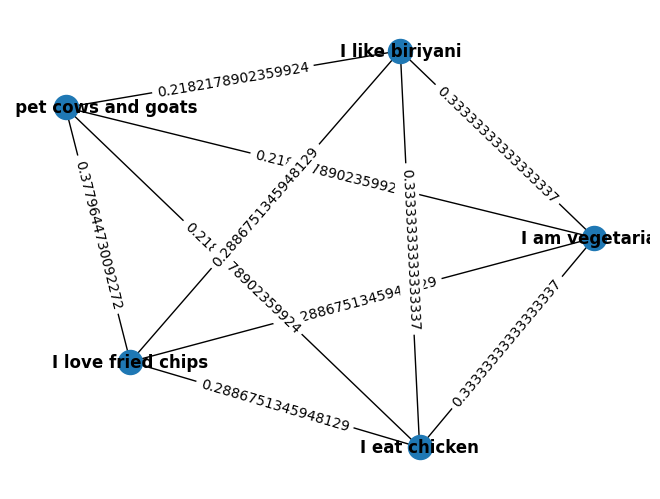

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Use the top 5 similar sentences for each query
num_similar = 5

# Create an empty graph
G = nx.Graph()

# Add nodes for each sentence
for sentence in sentence_vectors:
    G.add_node(sentence)

# Add edges with weights based on similarity scores
for sentence, vector in sentence_vectors.items():
    similar_sentences = vector_store.find_similar_vectors(vector, num_results=num_similar)
    for similar_sentence, similarity in similar_sentences:
        if sentence != similar_sentence:
            G.add_edge(sentence, similar_sentence, weight=similarity)

# Visualize the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
edge_labels = dict([((n1, n2), d['weight']) for n1, n2, d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()
